# Burger equation in 1D

We solve the following PDE:
$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
          u(t,x) - \theta \frac{\partial^2}{\partial x^2} u(t,x) = 0,\\
          u(0, x) = -\sin(\pi x), \text{ (initial condition)}\\
u(t,-1)=u(t,1)=0, \text{ (boundary condition)}
\end{cases}
$$

This has been studied in [this article](https://www.mdpi.com/2073-4441/13/4/423) for example

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create the neural network architecture for the PINN

In [5]:
eqx_list = [
    [eqx.nn.Linear, 2, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 1]
]
key, subkey = random.split(key)
u_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

Create the SPINN

In [6]:
d = 2
r = 256
eqx_list = [
    [eqx.nn.Linear, 1, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, r]
]
key, subkey = random.split(key)
u_spinn = jinns.utils.create_SPINN(subkey, d, r, eqx_list, "nonstatio_PDE")

In [7]:
init_nn_params_pinn = u_pinn.init_params()
init_nn_params_spinn = u_spinn.init_params()

Create a DataGenerator object. Note that the SPINN requires that the batches along each input dimension (here `t` and `x`) be of same length.

In [8]:
n = 1000
nt = 1000
nb = 2
omega_batch_size = 100
temporal_batch_size = 100
omega_border_batch_size = 1
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)

Let's plot the initial condition

## Model parameters

In [9]:
nu = 1 / (100 * jnp.pi)

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [10]:
init_params_pinn = {
    "nn_params":init_nn_params_pinn,
    "eq_params":{
        "nu":nu
    }
}
init_params_spinn = {
    "nn_params":init_nn_params_spinn,
    "eq_params":{
        "nu":nu
    }
}

## Initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

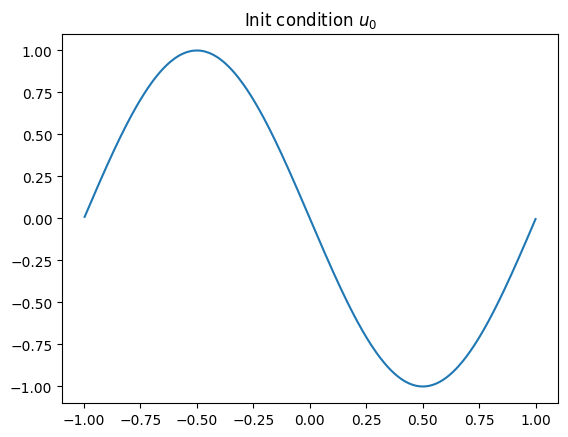

In [11]:
def u0(x):
    return -jnp.sin(jnp.pi * x)

plt.plot(train_data.omega.sort(axis=0), vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Loss construction

In [12]:
be_loss = jinns.loss.BurgerEquation(Tmax=Tmax)
loss_weights = {"dyn_loss":1, "initial_condition":100, "boundary_loss":1}

loss_pinn = jinns.loss.LossPDENonStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0
)

In [13]:
loss_weights = {"dyn_loss":1, "initial_condition":100, "boundary_loss":1}

loss_spinn = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0
)

## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

Train the PINN and plot loss values

In [14]:
params_pinn = init_params_pinn
import optax
tx = optax.adamw(learning_rate=1e-3)
n_iter = 10000
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 0: loss value = 0.5012165307998657
Iteration 1000: loss value = 0.10505311191082001
Iteration 2000: loss value = 0.10659247636795044
Iteration 3000: loss value = 0.1289689838886261
Iteration 4000: loss value = 0.03532430902123451
Iteration 5000: loss value = 0.03773795813322067
Iteration 6000: loss value = 0.07898865640163422
Iteration 7000: loss value = 0.18311826884746552
Iteration 8000: loss value = 0.04299740865826607
Iteration 9000: loss value = 0.12133844196796417
Iteration 10000: loss value = 0.02277528867125511


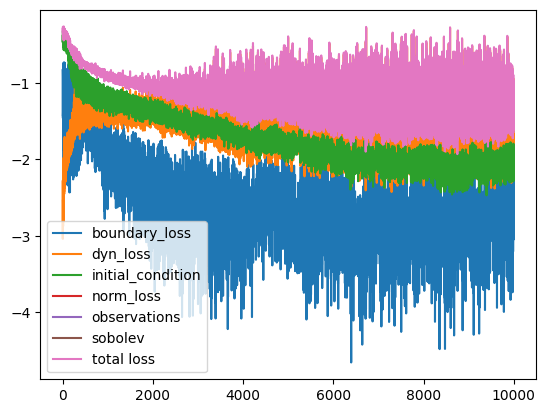

In [15]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

Train the SPINN and plot loss values

In [16]:
params_spinn = init_params_spinn
import optax
tx = optax.adamw(learning_rate=1e-3)
n_iter = 10000
params_spinn, total_loss_list_spinn, loss_by_term_dict_spinn, _, _, _, _ = jinns.solve(
    init_params=params_spinn,
    data=train_data,
    optimizer=tx,
    loss=loss_spinn,
    n_iter=n_iter
)

Iteration 0: loss value = 3.104307174682617


  0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 1000: loss value = 0.1890876740217209
Iteration 2000: loss value = 0.12118944525718689
Iteration 3000: loss value = 0.10367664694786072
Iteration 4000: loss value = 0.10395540297031403
Iteration 5000: loss value = 0.10223367810249329
Iteration 6000: loss value = 0.07648325711488724
Iteration 7000: loss value = 0.09621571004390717
Iteration 8000: loss value = 0.08107210695743561
Iteration 9000: loss value = 0.08837458491325378
Iteration 10000: loss value = 0.08178971707820892


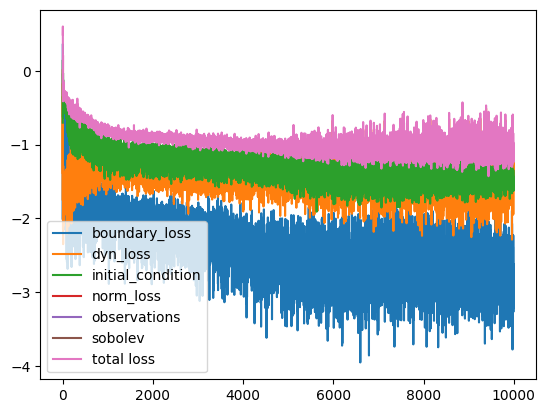

In [17]:
for loss_name, loss_values in loss_by_term_dict_spinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_spinn), label="total loss")
plt.legend()
plt.show()

Plot the solution learned by the PINN

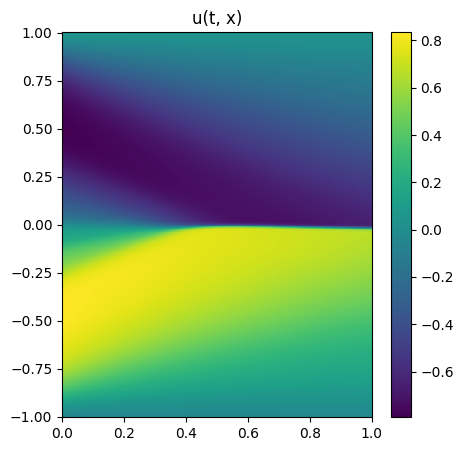

In [18]:
nx = 500
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

u_est_pinn = partial(u_pinn, u_params=params_pinn["nn_params"])
# same subkey
jinns.data.plot1d_image(u_est_pinn, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="u(t, x)")

Plot the solution learned by the SPINN

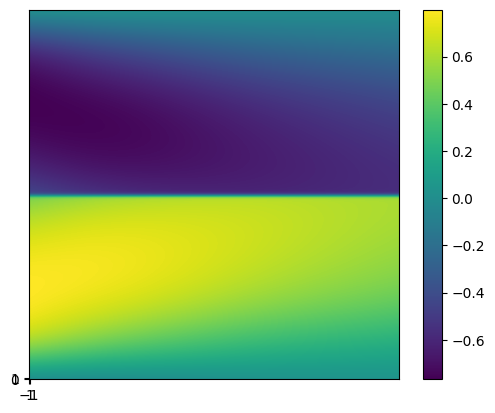

In [19]:
u_est_spinn = partial(u_spinn, u_params=params_spinn["nn_params"])

#jinns.data.plot1d_image(u_est, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(10,10), title="u(t, x)")
plt.imshow(u_est_spinn((val_times[..., None]), val_xdata[..., None]).T, origin="lower")
plt.xticks((xmin, xmax))
plt.yticks((tmin, Tmax))
plt.colorbar()
plt.show()

In [20]:
plt.imshow((u_est_spinn((val_times[..., None]), val_xdata[..., None]).T) - 

SyntaxError: incomplete input (3024951563.py, line 1)

In [ ]:
time_slices = [0, 0.2, 0.4, 0.75, 0.95, 1.]
jinns.data.plot1d_slice(u_est, xdata=val_xdata, time_slices=time_slices)

Save the estimated solution grid values

In [ ]:
# x = test_data.omega.sort(axis=0).squeeze()
# t = test_data.times.sort(axis=0).squeeze()
# tv, xv = jnp.meshgrid(t, x)
# jnp.save("burger_t_grid.npy", tv)
# jnp.save("burger_x_grid.npy", xv)

# values = u_est_fp(tv.reshape((nt * n, 1)), xv.reshape((nt * n, 1)))
# grid = values.reshape(n, nt)
# jnp.save("burger_solution_grid.npy",
#     jnp.stack(
#         [tv, xv, grid],
#         axis=-1
#     )
# )
